# Tuning SARIMAX models on residuals for each cluster

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_0 = pd.read_csv('cluster_0.csv', index_col=0)
data_1 = pd.read_csv('cluster_1.csv', index_col=0)
data_2 = pd.read_csv('cluster_2.csv', index_col=0)
data_3 = pd.read_csv('cluster_3.csv', index_col=0)
data_4 = pd.read_csv('cluster_4.csv', index_col=0)

In [3]:
series_0 = pd.DataFrame(data_0['value_mean'])
series_0 = series_0.set_index(pd.date_range('01/01/2016', periods=int(data_0.shape[0]), freq='H'))
series_1 = pd.DataFrame(data_1['value_mean'])
series_1 = series_1.set_index(pd.date_range('01/01/2016', periods=int(data_1.shape[0]), freq='H'))
series_2 = pd.DataFrame(data_2['value_mean'])
series_2 = series_2.set_index(pd.date_range('01/01/2016', periods=int(data_2.shape[0]), freq='H'))
series_3 = pd.DataFrame(data_3['value_mean'])
series_3 = series_3.set_index(pd.date_range('01/01/2016', periods=int(data_3.shape[0]), freq='H'))
series_4 = pd.DataFrame(data_4['value_mean'])
series_4 = series_4.set_index(pd.date_range('01/01/2016', periods=int(data_4.shape[0]), freq='H'))

Let's use running mean and weekend\holiday features for regression

In [4]:
def make_regressive_features(series):
    for i in range(1, 6):
        series['sin_value_{}'.format(i)] = np.sin(np.arange(series.shape[0]) * 2*np.pi * i/720)
        series['cos_value_{}'.format(i)] = np.cos(np.arange(series.shape[0]) * 2*np.pi * i/720)
#         if i % 12 == 0:
#             series['shift_{}'.format(i)] = series['value_mean'].rolling(i).mean()
    series['roll_12'.format(i)] = series['value_mean'].rolling(12).mean()
    series['roll_24'.format(i)] = series['value_mean'].rolling(24).mean()
    series['roll_96'.format(i)] = series['value_mean'].rolling(96).mean()
    series['roll_96'.format(i)] = series['value_mean'].rolling(168).mean()
    isWeekend = lambda x: 1 if x in (5, 6) else 0
    series['is_weekend'] = [isWeekend(i) for i in series.index.dayofweek]
    series['is_new_year'] = [(lambda x: 1 if (x[0]==1 & x[1]==1) else 0)(x) for x in zip(series.index.day,
                                                                                           series.index.month)]
    series['is_martin_luther'] = [(lambda x: 1 if (x[0]==18 & x[1]==1) else 0)(x) for x in zip(series.index.day,
                                                                                           series.index.month)]
    series['is_presidents_day'] = [(lambda x: 1 if (x[0]==15 & x[1]==2) else 0)(x) for x in zip(series.index.day,
                                                                                           series.index.month)]
    series['is_emancipation_day'] = [(lambda x: 1 if (x[0]==15 & x[1]==4) else 0)(x) for x in zip(series.index.day,
                                                                                           series.index.month)]
    return series

In [5]:
series_0 = make_regressive_features(series_0)
series_1 = make_regressive_features(series_1)
series_2 = make_regressive_features(series_2)
series_3 = make_regressive_features(series_3)
series_4 = make_regressive_features(series_4)

In [8]:
regressor = LinearRegression()

# Cluster 1

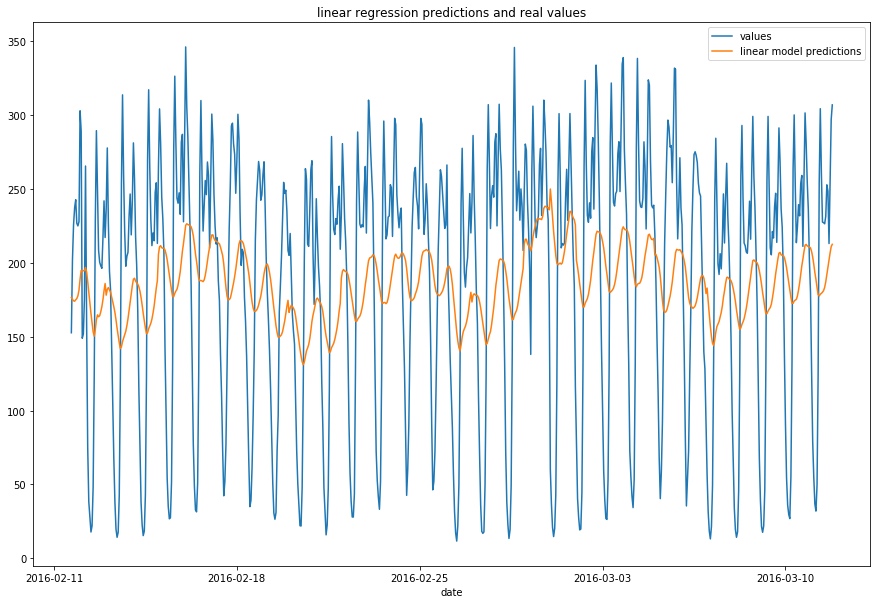

In [267]:
regressor.fit(series_0.drop(['value_mean'], axis=1).fillna(0), series_0['value_mean'])
plt.figure(figsize(15,10))
plt.plot(series_0.value_mean[1000:1700], label='values')
plt.plot(series_0.index[1000:1700], regressor.predict(series_0.drop(['value_mean'], axis=1).fillna(0))[1000:1700], 
         label='linear model predictions')
plt.xlabel('date')
plt.title('linear regression predictions and real values')
plt.legend()
plt.show()

Our regression features can describe a time series pretty well. But still, let's have a look at residuals and tune SARIMAX model

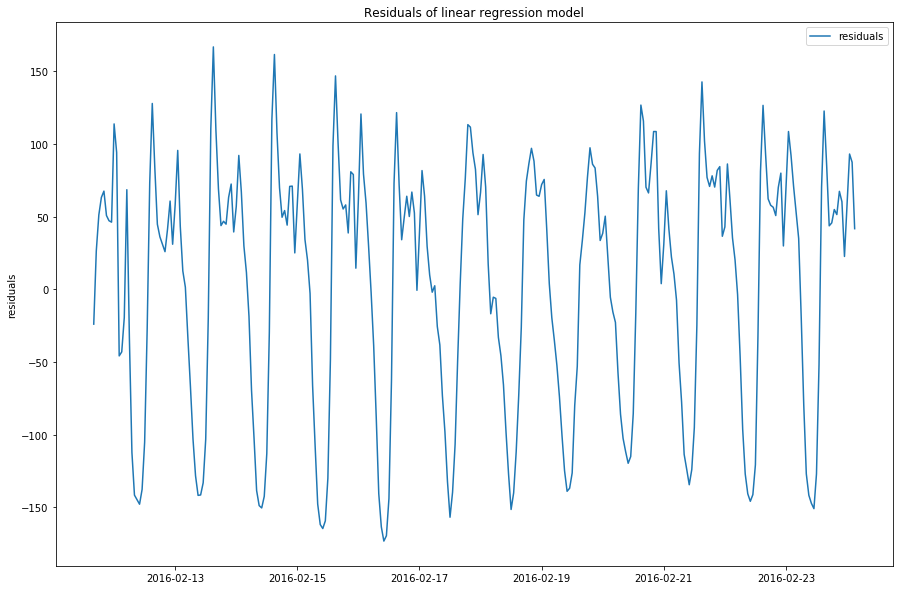

In [268]:
plt.figure(figsize(15,10))
series_0['predictions'] = regressor.predict(series_0.drop(['value_mean'], axis=1).fillna(0))
series_0['residuals'] = series_0['value_mean'] - series_0['predictions']
plt.plot(series_0.residuals[1000:1300], label='residuals')
plt.ylabel('residuals')
plt.title('Residuals of linear regression model')
plt.legend()
plt.show()

Dickey-Fuller test:

H0: time series is not static

H1: H0 is incorrect

In [12]:
import statsmodels.api as sm

Dickey - Fuller test: p-value = 2.995129028614013e-14


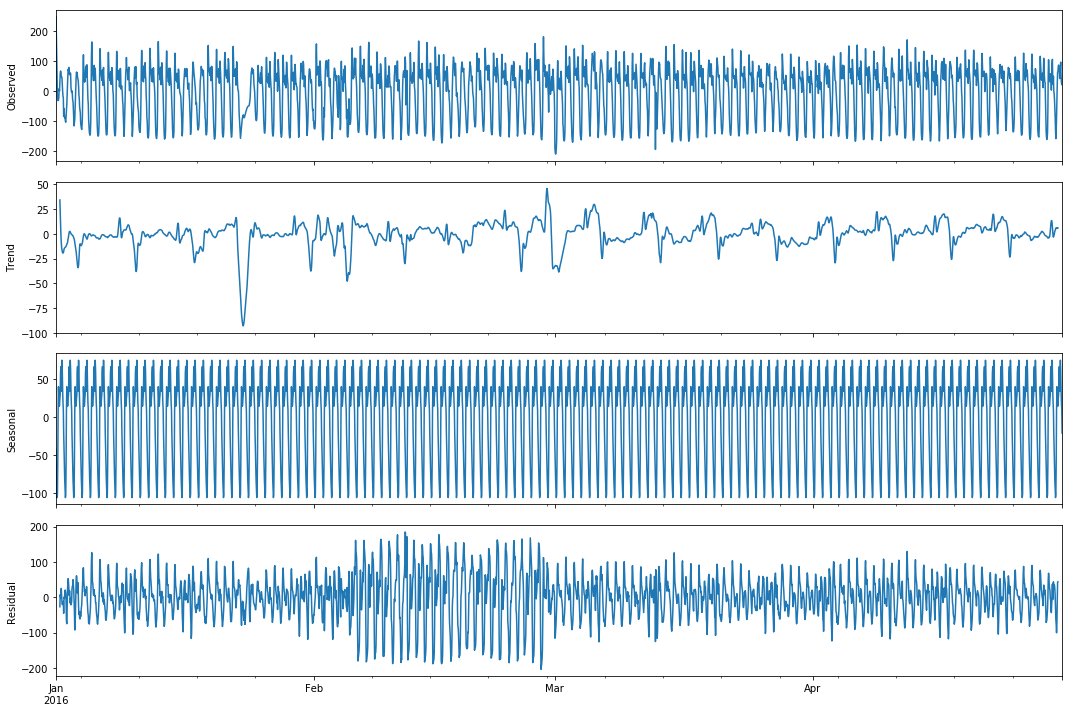

In [270]:
print("Dickey - Fuller test: p-value = {}".format(sm.tsa.stattools.adfuller(series_0.residuals)[1]))
sm.tsa.seasonal_decompose(series_0.residuals).plot()
plt.show()

STL-decomposition looks fine. Let's try to tune SARIMAX model

In [ ]:
series_0['residuals_24'] = series_0['residuals'] - series_0['residuals'].shift(24)

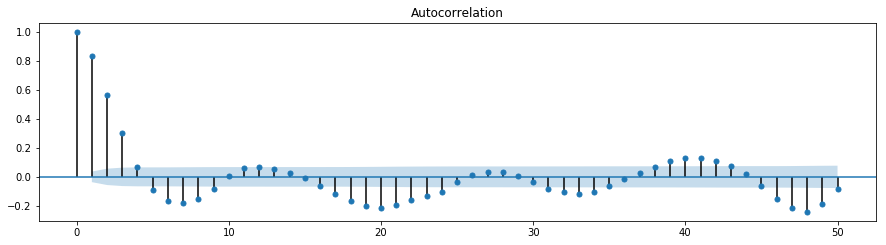

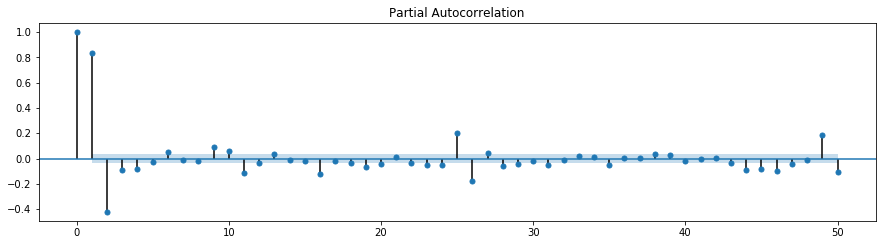

In [278]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(series_0.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(series_0.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()

Q = 1, q = 7

P = 2, p = 2

D = 1, d = 0

We should take bigger values for parameters. Because of calculation time and nice residuals plot we will constrain on smaller ones

In [279]:
from itertools import product
D = 1
d = 0
ps = range(3)
qs = range(8)
Ps = range(3)
Qs = range(2)
parameters_list_0 = list(product(ps, qs, Ps, Qs))
print('amount of different models: {}'.format(len(parameters_list_0)))

amount of different models: 144


In [280]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for i, param in enumerate(parameters_list_0):
    try:
        model = sm.tsa.statespace.SARIMAX(series_0.residuals,
                                          order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_0 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print('{} out of {} '.format(i, len(parameters_list_0)))
    
warnings.filterwarnings('default')

0 out of 144 
1 out of 144 
2 out of 144 
3 out of 144 
4 out of 144 
5 out of 144 
12 out of 144 
13 out of 144 
14 out of 144 
15 out of 144 
16 out of 144 
17 out of 144 
18 out of 144 
19 out of 144 
20 out of 144 
21 out of 144 
22 out of 144 
23 out of 144 
24 out of 144 
25 out of 144 
26 out of 144 
27 out of 144 
28 out of 144 
29 out of 144 
30 out of 144 
31 out of 144 
32 out of 144 
33 out of 144 
34 out of 144 
35 out of 144 
36 out of 144 
37 out of 144 
38 out of 144 
39 out of 144 
40 out of 144 
41 out of 144 
42 out of 144 
43 out of 144 
44 out of 144 
45 out of 144 
46 out of 144 
47 out of 144 
48 out of 144 
49 out of 144 
50 out of 144 
51 out of 144 
52 out of 144 
53 out of 144 
54 out of 144 
55 out of 144 
56 out of 144 
57 out of 144 
58 out of 144 
59 out of 144 
60 out of 144 
61 out of 144 
62 out of 144 
63 out of 144 
64 out of 144 
65 out of 144 
66 out of 144 
67 out of 144 
68 out of 144 
69 out of 144 
70 out of 144 
71 out of 144 
72 out of 144 
7

In [296]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
best_params_dict = {} # place to store best params for every cluster

       parameters           aic
137  (2, 7, 2, 1)  25913.133473
119  (2, 4, 2, 1)  25922.309897
131  (2, 6, 2, 1)  25923.506180
125  (2, 5, 2, 1)  25924.119739
107  (2, 2, 2, 1)  25927.333380


In [295]:
best_params_dict['cluster 1'] = (2, 7, 2, 1)

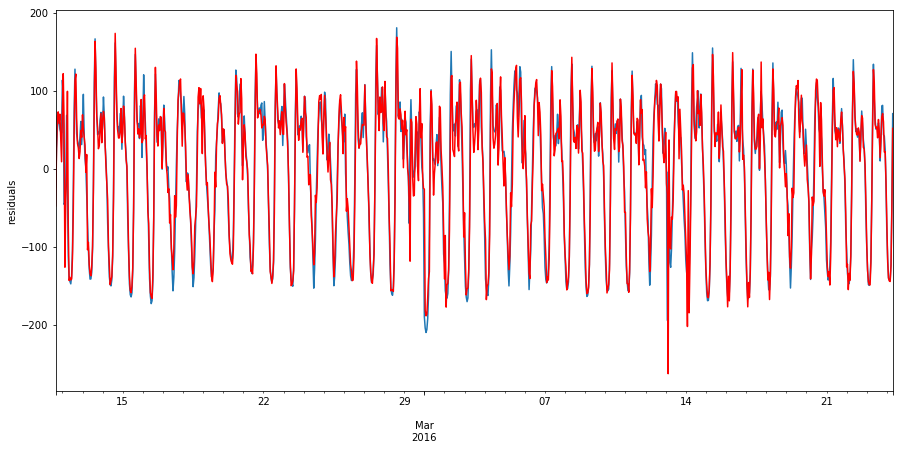

In [298]:
series_0['model'] = best_model_0.fittedvalues
plt.figure(figsize(15,7))
series_0.residuals[1000:2000].plot()
series_0.model[1000:2000].plot(color='r')
plt.ylabel('residuals')
pylab.show()

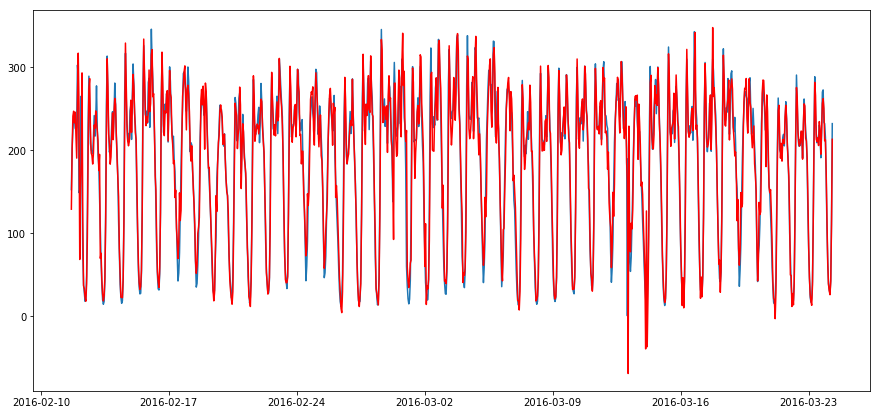

In [309]:
series_0['model'] = best_model_0.fittedvalues
series_0['final_predict'] = series_0.model + series_0.predictions
plt.figure(figsize(15,7))
plt.plot(series_0.value_mean[1000:2000])
plt.plot(series_0.final_predict[1000:2000], color='r')
pylab.show()

## Best model

In [310]:
print(best_model_0.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          residuals   No. Observations:                 2904
Model:             SARIMAX(2, 0, 7)x(2, 1, 1, 24)   Log Likelihood              -12943.567
Date:                            Mon, 08 Oct 2018   AIC                          25913.133
Time:                                    23:12:44   BIC                          25990.686
Sample:                                01-01-2016   HQIC                         25941.087
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6561      0.021     79.365      0.000       1.615       1.697
ar.L2         -0.9082      0.020   

# Cluster 2

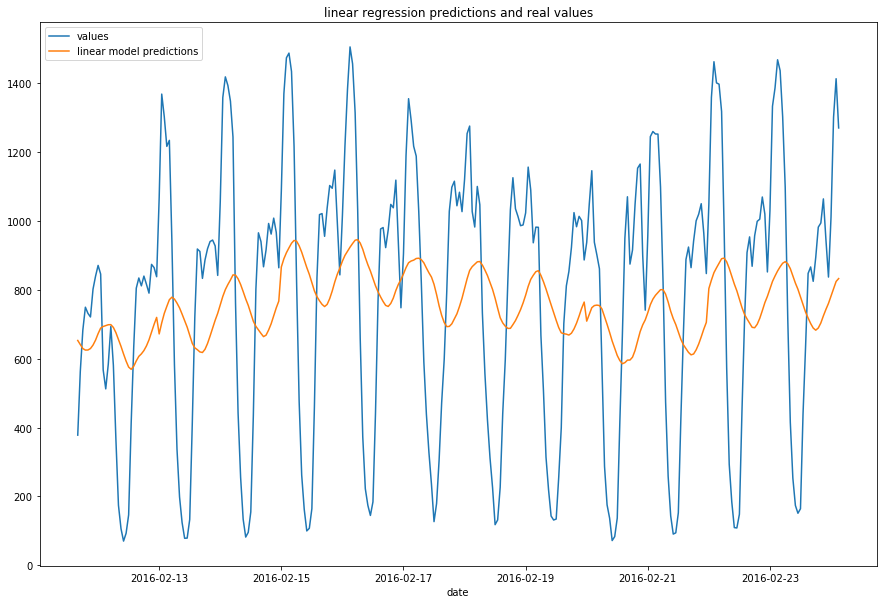

In [311]:
regressor.fit(series_1.drop(['value_mean'], axis=1).fillna(0), series_1['value_mean'])
plt.figure(figsize(15,10))
plt.plot(series_1.value_mean[1000:1300], label='values')
plt.plot(series_1.index[1000:1300], regressor.predict(series_1.drop(['value_mean'], axis=1).fillna(0))[1000:1300], 
         label='linear model predictions')
plt.xlabel('date')
plt.title('linear regression predictions and real values')
plt.legend()
plt.show()

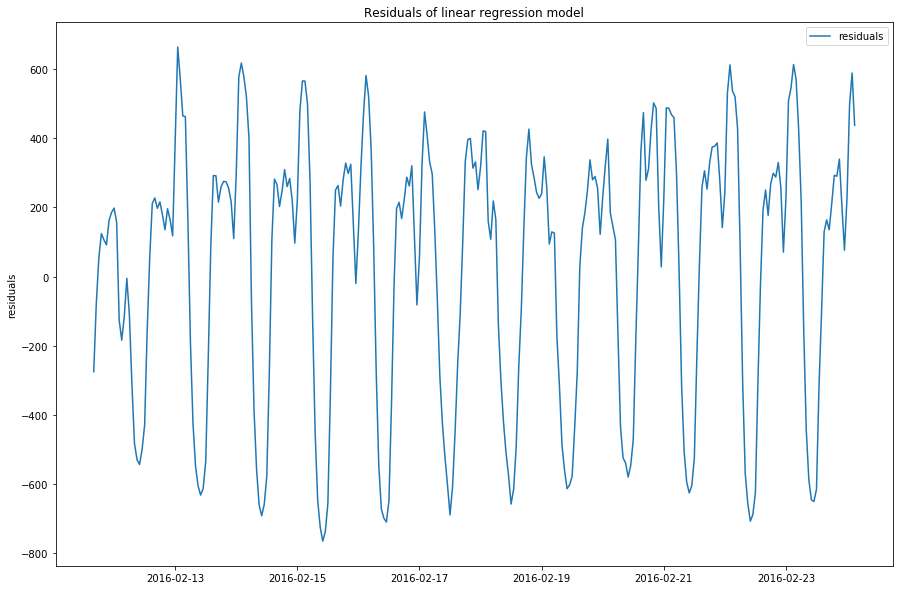

In [312]:
plt.figure(figsize(15,10))
series_1['predictions'] = regressor.predict(series_1.drop(['value_mean'], axis=1).fillna(0))
series_1['residuals'] = series_1['value_mean'] - series_1['predictions']
plt.plot(series_1.residuals[1000:1300], label='residuals')
plt.ylabel('residuals')
plt.title('Residuals of linear regression model')
plt.legend()
plt.show()

Dickey - Fuller test: p-value = 1.0081715665077536e-14


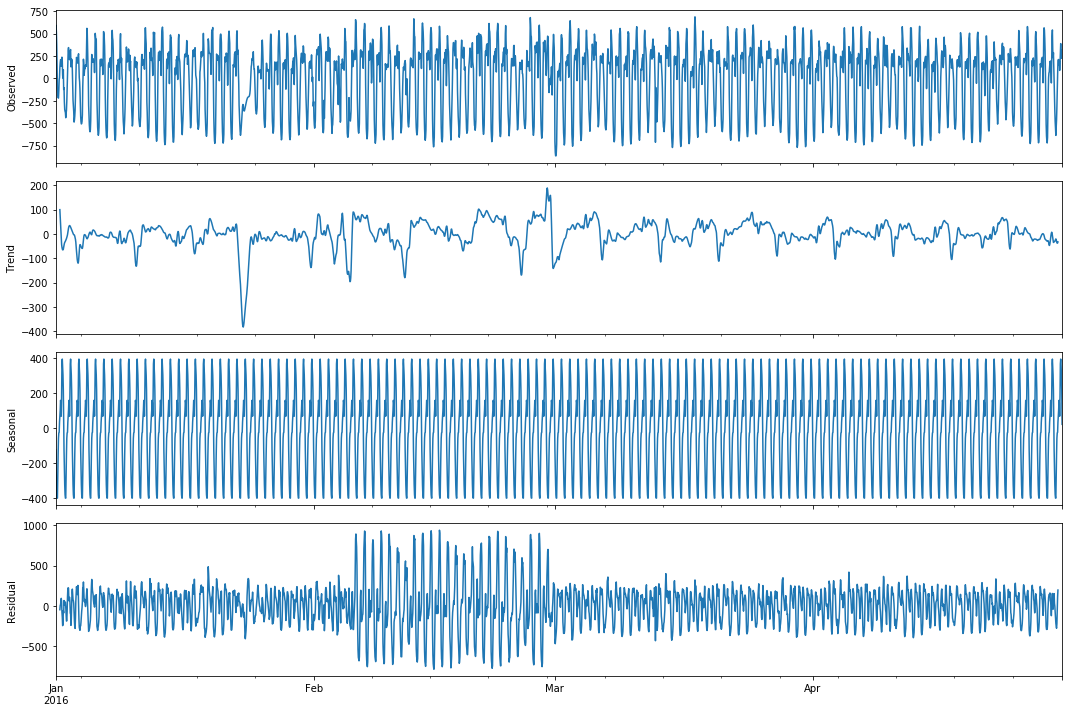

In [313]:
print("Dickey - Fuller test: p-value = {}".format(sm.tsa.stattools.adfuller(series_1.residuals)[1]))
sm.tsa.seasonal_decompose(series_1.residuals).plot()
plt.show()

In [317]:
series_1['residuals_24'] = series_1['residuals'] - series_1['residuals'].shift(24)

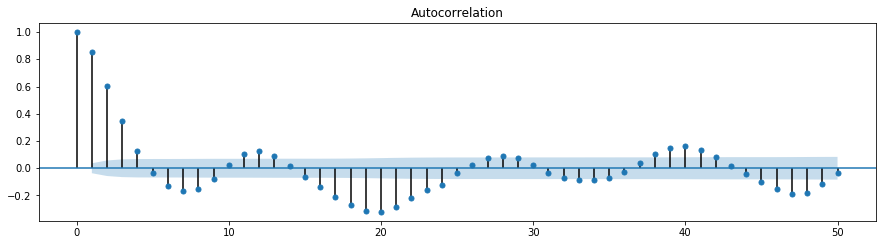

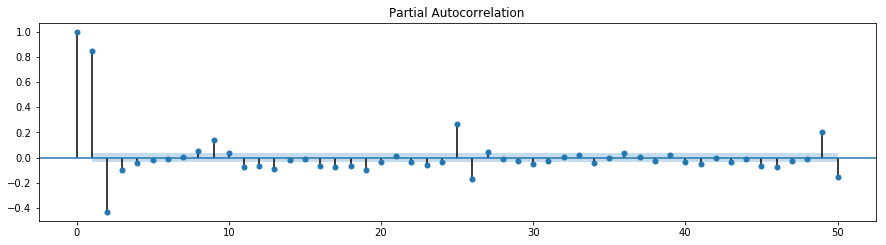

In [345]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(series_1.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(series_1.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()

q = 3; Q = 2

p = 2; P = 2

d = 0; D = 1

In [346]:
D = 1
d = 0
ps = range(3)
qs = range(4)
Ps = range(3)
Qs = range(3)
parameters_list_1 = list(product(ps, qs, Ps, Qs))
print('amount of different models: {}'.format(len(parameters_list_1)))

amount of different models: 108


In [348]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for i, param in enumerate(parameters_list_1):
    try:
        model = sm.tsa.statespace.SARIMAX(series_1.residuals,
                                          order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_1 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print('{} out of {} '.format(i, len(parameters_list_1)))
    
warnings.filterwarnings('default')

0 out of 108 
1 out of 108 
2 out of 108 
3 out of 108 
4 out of 108 
5 out of 108 
6 out of 108 
7 out of 108 
8 out of 108 
27 out of 108 
28 out of 108 
29 out of 108 
30 out of 108 
31 out of 108 
32 out of 108 
33 out of 108 
34 out of 108 
35 out of 108 
36 out of 108 
37 out of 108 
38 out of 108 
39 out of 108 
40 out of 108 
41 out of 108 
42 out of 108 
43 out of 108 
44 out of 108 
45 out of 108 
46 out of 108 
47 out of 108 
48 out of 108 
49 out of 108 
50 out of 108 
51 out of 108 
52 out of 108 
53 out of 108 
54 out of 108 
55 out of 108 
56 out of 108 
57 out of 108 
58 out of 108 
59 out of 108 
60 out of 108 
61 out of 108 
62 out of 108 
63 out of 108 
64 out of 108 
65 out of 108 
66 out of 108 
67 out of 108 
68 out of 108 
69 out of 108 
70 out of 108 
71 out of 108 
72 out of 108 
73 out of 108 
74 out of 108 
75 out of 108 
76 out of 108 
77 out of 108 
78 out of 108 
79 out of 108 
80 out of 108 
81 out of 108 
82 out of 108 
83 out of 108 
84 out of 108 
85 o

In [349]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
80  (2, 2, 2, 2)  33268.959554
89  (2, 3, 2, 2)  33271.912805
71  (2, 1, 2, 2)  33275.226888
62  (2, 0, 2, 2)  33312.992529
79  (2, 2, 2, 1)  33324.125221


In [352]:
series_1['model'] = best_model_1.fittedvalues
series_1['final_predict'] = series_1.model + series_1.predictions
best_params_dict['cluster 2'] = (2, 2, 2, 2)

## Best model

In [353]:
print(best_model_1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          residuals   No. Observations:                 2904
Model:             SARIMAX(2, 0, 2)x(2, 1, 2, 24)   Log Likelihood              -16625.480
Date:                            Tue, 09 Oct 2018   AIC                          33268.960
Time:                                    03:24:45   BIC                          33322.649
Sample:                                01-01-2016   HQIC                         33288.312
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5608      0.027     57.798      0.000       1.508       1.614
ar.L2         -0.7140      0.020   

# Cluster 3

In [358]:
series_2.head()

,value_mean,sin_value_1,cos_value_1,sin_value_2,cos_value_2,sin_value_3,cos_value_3,sin_value_4,cos_value_4,sin_value_5,...,roll_24,roll_96,is_weekend,is_new_year,is_martin_luther,is_presidents_day,is_emancipation_day,predictions,residuals,residuals_24
2016-01-01 00:00:00,702.375,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,NaN,NaN,0,1,0,0,0,160.647225,541.727775,NaN
2016-01-01 01:00:00,641.000,0.008727,0.999962,0.017452,0.999848,0.026177,0.999657,0.034899,0.999391,0.043619,...,NaN,NaN,0,1,0,0,0,160.911716,480.088284,NaN
2016-01-01 02:00:00,544.250,0.017452,0.999848,0.034899,0.999391,0.052336,0.998630,0.069756,0.997564,0.087156,...,NaN,NaN,0,1,0,0,0,161.160621,383.089379,NaN
2016-01-01 03:00:00,566.250,0.026177,0.999657,0.052336,0.998630,0.078459,0.996917,0.104528,0.994522,0.130526,...,NaN,NaN,0,1,0,0,0,161.393711,404.856289,NaN
2016-01-01 04:00:00,482.000,0.034899,0.999391,0.069756,0.997564,0.104528,0.994522,0.139173,0.990268,0.173648,...,NaN,NaN,0,1,0,0,0,161.610775,320.389225,NaN


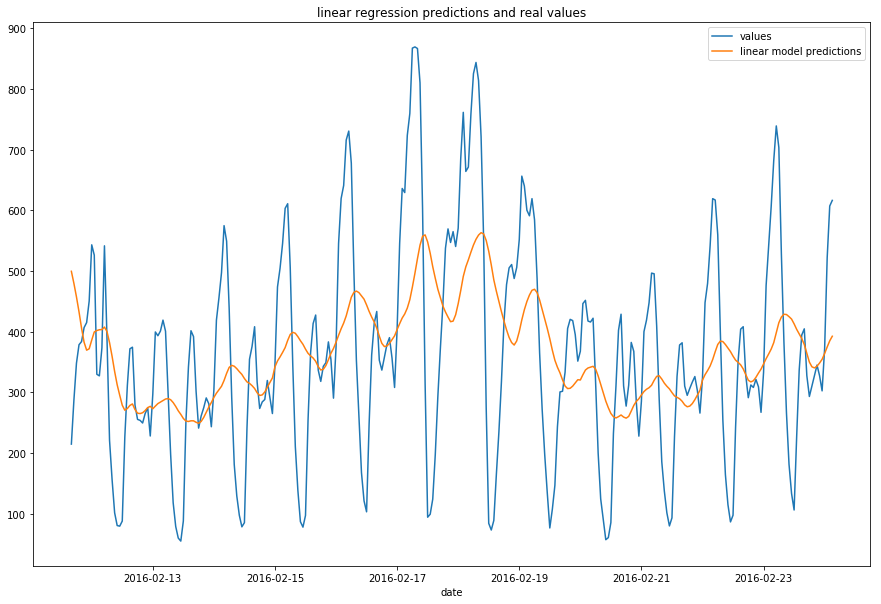

In [360]:
regressor.fit(series_2.drop(['value_mean'], axis=1).fillna(0), series_2['value_mean'])
plt.figure(figsize(15,10))
plt.plot(series_2.value_mean[1000:1300], label='values')
plt.plot(series_2.index[1000:1300], regressor.predict(series_2.drop(['value_mean'], axis=1).fillna(0))[1000:1300], 
         label='linear model predictions')
plt.xlabel('date')
plt.title('linear regression predictions and real values')
plt.legend()
plt.show()

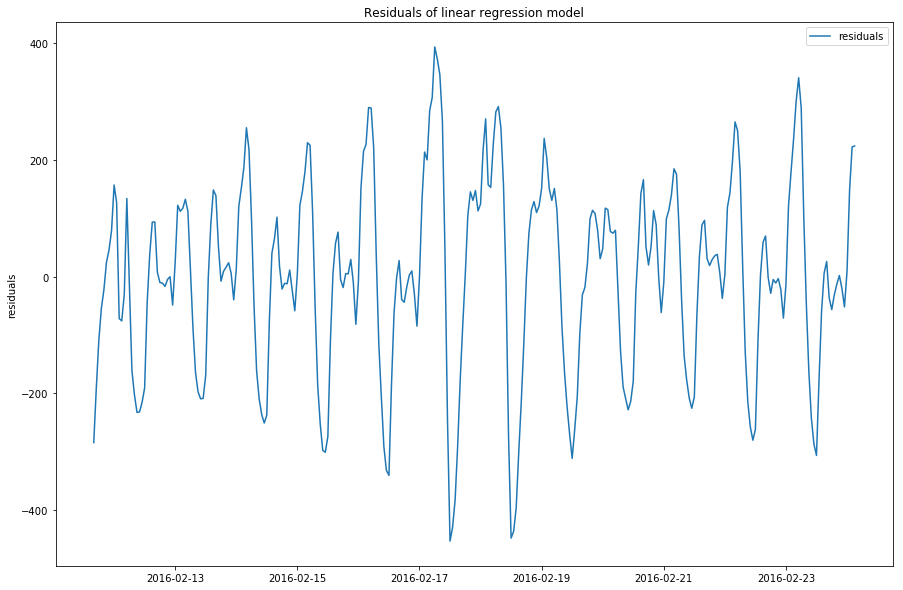

In [322]:
plt.figure(figsize(15,10))
series_2['predictions'] = regressor.predict(series_2.drop(['value_mean'], axis=1).fillna(0))
series_2['residuals'] = series_2['value_mean'] - series_2['predictions']
plt.plot(series_2.residuals[1000:1300], label='residuals')
plt.ylabel('residuals')
plt.title('Residuals of linear regression model')
plt.legend()
plt.show()

Dickey - Fuller test: p-value = 8.660847146627757e-15


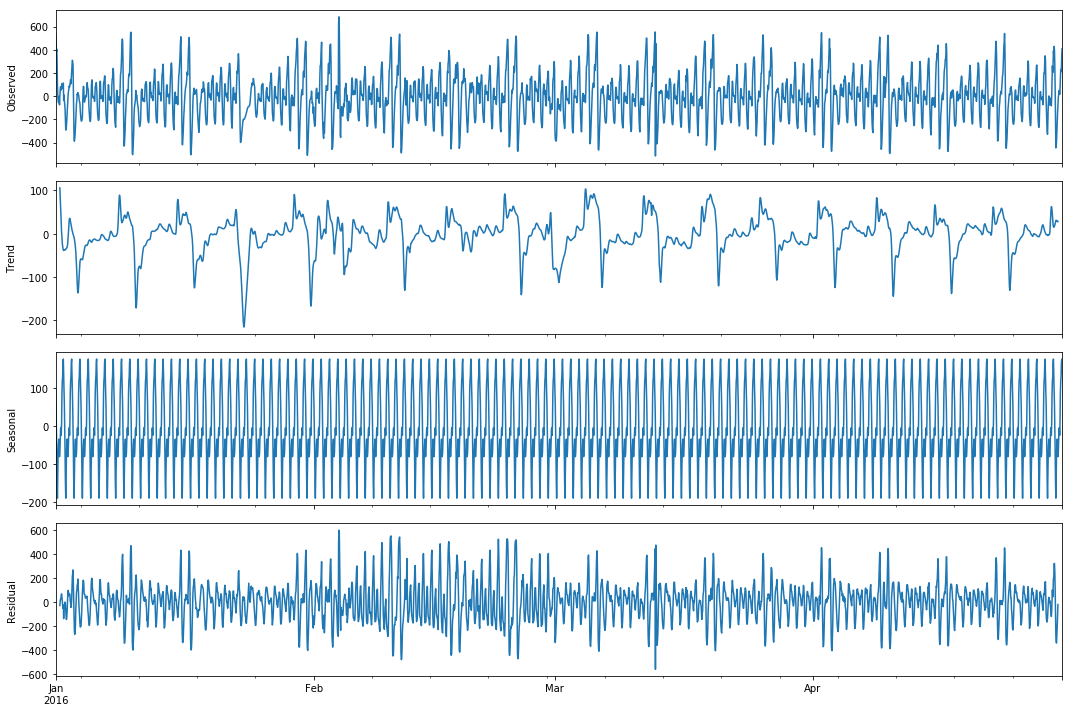

In [323]:
print("Dickey - Fuller test: p-value = {}".format(sm.tsa.stattools.adfuller(series_2.residuals)[1]))
sm.tsa.seasonal_decompose(series_2.residuals).plot()
plt.show()

In [325]:
series_2['residuals_24'] = series_2['residuals'] - series_2['residuals'].shift(24)

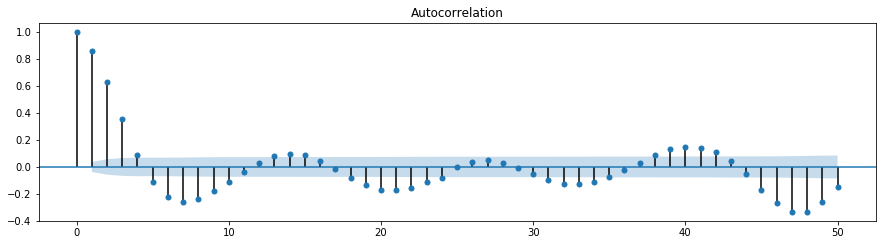

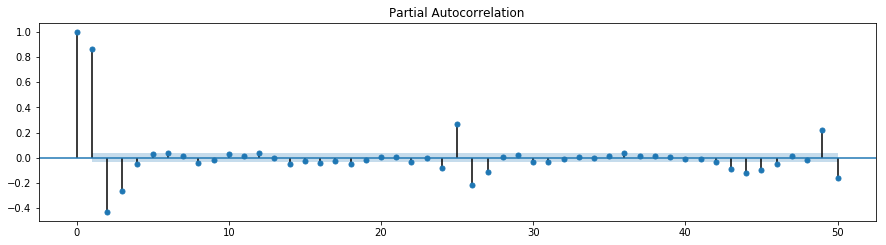

In [326]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(series_2.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(series_2.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()

q = 3; Q = 0

p = 3; P = 2

d = 0; D = 1

In [361]:
D = 1
d = 0
ps = range(4)
qs = range(4)
Ps = range(3)
Qs = range(1)
parameters_list_2 = list(product(ps, qs, Ps, Qs))
print('amount of different models: {}'.format(len(parameters_list_2)))

amount of different models: 48


In [362]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for i, param in enumerate(parameters_list_2):
    try:
        model = sm.tsa.statespace.SARIMAX(series_2.residuals,
                                          order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_2 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print('{} out of {} '.format(i, len(parameters_list_2)))
    
warnings.filterwarnings('default')

0 out of 48 
1 out of 48 
2 out of 48 
9 out of 48 
10 out of 48 
11 out of 48 
12 out of 48 
13 out of 48 
14 out of 48 
15 out of 48 
16 out of 48 
17 out of 48 
18 out of 48 
19 out of 48 
20 out of 48 
21 out of 48 
22 out of 48 
23 out of 48 
24 out of 48 
25 out of 48 
26 out of 48 
27 out of 48 
28 out of 48 
29 out of 48 
30 out of 48 
31 out of 48 
32 out of 48 
33 out of 48 
34 out of 48 
35 out of 48 
36 out of 48 
37 out of 48 
38 out of 48 
39 out of 48 
40 out of 48 
41 out of 48 
42 out of 48 
43 out of 48 
44 out of 48 
Wall time: 9min 41s


In [363]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
26  (2, 2, 2, 0)  32236.851822
29  (2, 3, 2, 0)  32237.750288
38  (3, 2, 2, 0)  32238.005175
32  (3, 0, 2, 0)  32244.713636
35  (3, 1, 2, 0)  32246.360225


In [365]:
best_params_dict['cluster 3'] = (2, 2, 2, 0)
series_2['model'] = best_model_2.fittedvalues
series_2['final_predict'] = series_2.model + series_2.predictions

## Best model

In [366]:
print(best_model_2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          residuals   No. Observations:                 2904
Model:             SARIMAX(2, 0, 2)x(2, 1, 0, 24)   Log Likelihood              -16111.426
Date:                            Tue, 09 Oct 2018   AIC                          32236.852
Time:                                    03:39:56   BIC                          32278.611
Sample:                                01-01-2016   HQIC                         32251.904
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5242      0.026     59.516      0.000       1.474       1.574
ar.L2         -0.7260      0.022   

# Cluster 4

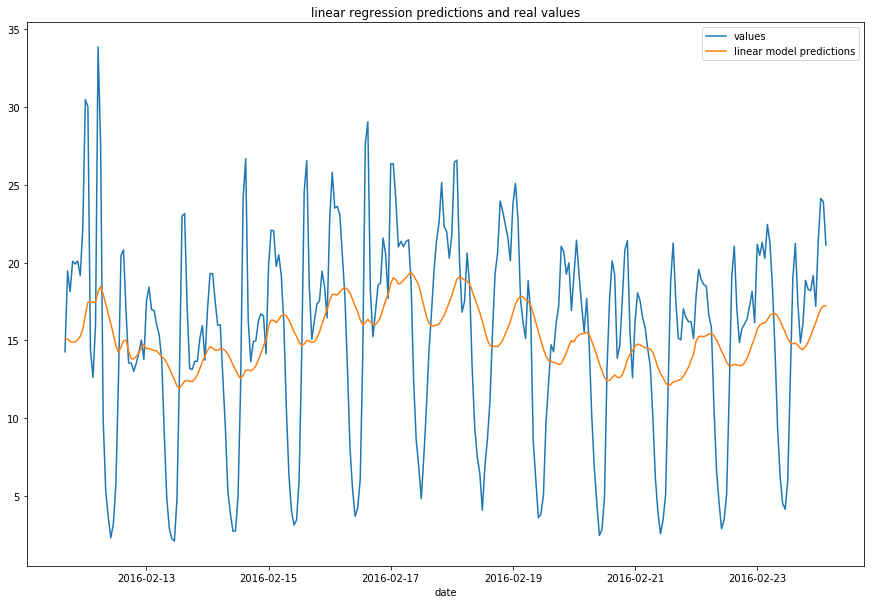

In [328]:
regressor.fit(series_3.drop(['value_mean'], axis=1).fillna(0), series_3['value_mean'])
plt.figure(figsize(15,10))
plt.plot(series_3.value_mean[1000:1300], label='values')
plt.plot(series_3.index[1000:1300], regressor.predict(series_3.drop(['value_mean'], axis=1).fillna(0))[1000:1300], 
         label='linear model predictions')
plt.xlabel('date')
plt.title('linear regression predictions and real values')
plt.legend()
plt.show()

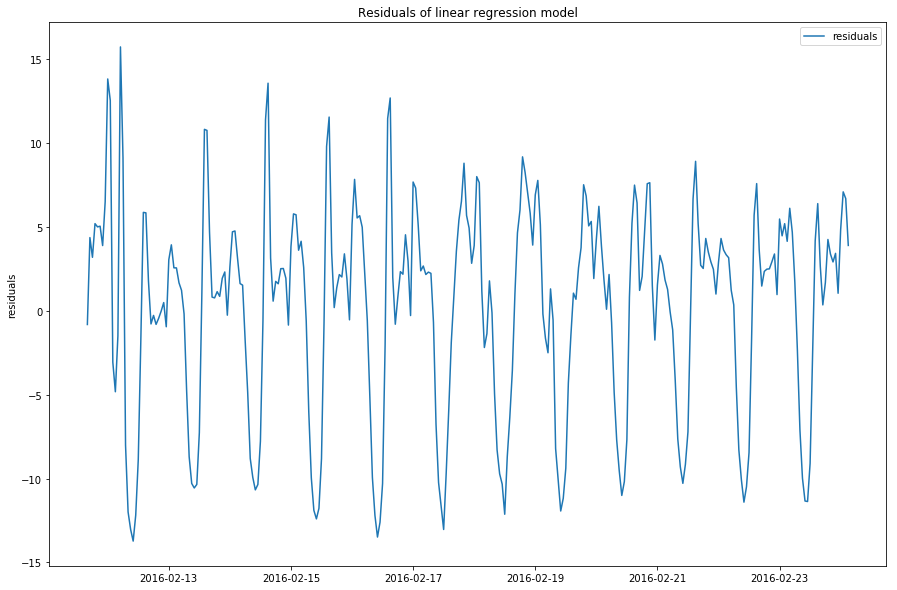

In [329]:
plt.figure(figsize(15,10))
series_3['predictions'] = regressor.predict(series_3.drop(['value_mean'], axis=1).fillna(0))
series_3['residuals'] = series_3['value_mean'] - series_3['predictions']
plt.plot(series_3.residuals[1000:1300], label='residuals')
plt.ylabel('residuals')
plt.title('Residuals of linear regression model')
plt.legend()
plt.show()

Dickey - Fuller test: p-value = 1.802476996786352e-12


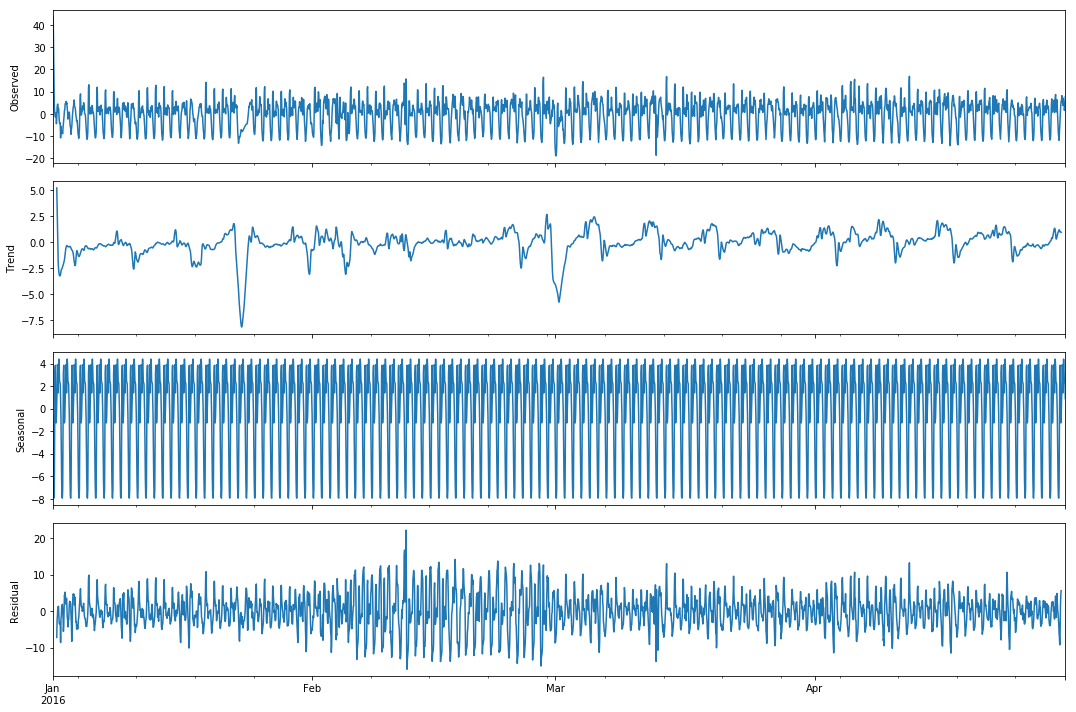

In [330]:
print("Dickey - Fuller test: p-value = {}".format(sm.tsa.stattools.adfuller(series_3.residuals)[1]))
sm.tsa.seasonal_decompose(series_3.residuals).plot()
plt.show()

In [333]:
series_3['residuals_24'] = series_3['residuals'] - series_3['residuals'].shift(24)

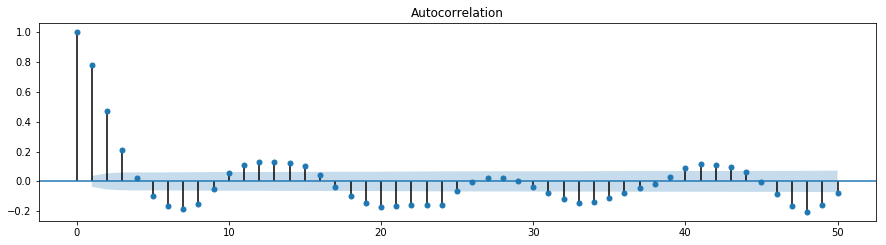

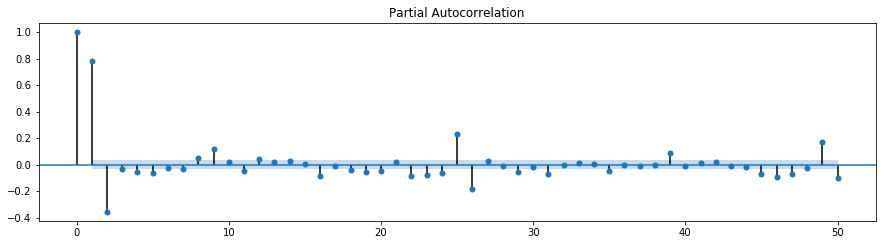

In [367]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(series_3.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(series_3.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()

q = 3; Q = 2;

p = 2; P = 2;

d = 0; D = 0

In [368]:
D = 1
d = 0
ps = range(3)
qs = range(4)
Ps = range(3)
Qs = range(3)
parameters_list_3 = list(product(ps, qs, Ps, Qs))
print('amount of different models: {}'.format(len(parameters_list_3)))

amount of different models: 108


In [369]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for i, param in enumerate(parameters_list_3):
    try:
        model = sm.tsa.statespace.SARIMAX(series_3.residuals,
                                          order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_3 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print('{} out of {} '.format(i, len(parameters_list_3)))
    
warnings.filterwarnings('default')

0 out of 108 
1 out of 108 
2 out of 108 
3 out of 108 
4 out of 108 
5 out of 108 
6 out of 108 
7 out of 108 
8 out of 108 
18 out of 108 
19 out of 108 
20 out of 108 
21 out of 108 
22 out of 108 
23 out of 108 
24 out of 108 
25 out of 108 
26 out of 108 
27 out of 108 
28 out of 108 
29 out of 108 
30 out of 108 
31 out of 108 
32 out of 108 
33 out of 108 
34 out of 108 
35 out of 108 
36 out of 108 
37 out of 108 
38 out of 108 
39 out of 108 
40 out of 108 
41 out of 108 
42 out of 108 
43 out of 108 
44 out of 108 
45 out of 108 
46 out of 108 
47 out of 108 
48 out of 108 
49 out of 108 
50 out of 108 
51 out of 108 
52 out of 108 
53 out of 108 
54 out of 108 
55 out of 108 
56 out of 108 
57 out of 108 
58 out of 108 
59 out of 108 
60 out of 108 
61 out of 108 
62 out of 108 
63 out of 108 
64 out of 108 
65 out of 108 
66 out of 108 
67 out of 108 
68 out of 108 
69 out of 108 
70 out of 108 
71 out of 108 
72 out of 108 
73 out of 108 
74 out of 108 
75 out of 108 
76 o

In [370]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
89  (2, 2, 2, 2)  12880.933914
98  (2, 3, 2, 2)  12882.868329
88  (2, 2, 2, 1)  12903.985748
83  (2, 2, 0, 2)  12904.550710
97  (2, 3, 2, 1)  12905.972173


In [373]:
best_params_dict['cluster 4'] = (2, 2, 2, 2)
series_3['model'] = best_model_3.fittedvalues
series_3['final_predict'] = series_3.model + series_3.predictions

## Best model

In [374]:
print(best_model_3.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          residuals   No. Observations:                 2904
Model:             SARIMAX(2, 0, 2)x(2, 1, 2, 24)   Log Likelihood               -6431.467
Date:                            Tue, 09 Oct 2018   AIC                          12880.934
Time:                                    12:01:49   BIC                          12934.624
Sample:                                01-01-2016   HQIC                         12900.286
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5112      0.027     56.218      0.000       1.459       1.564
ar.L2         -0.6684      0.016   

# Cluster 5

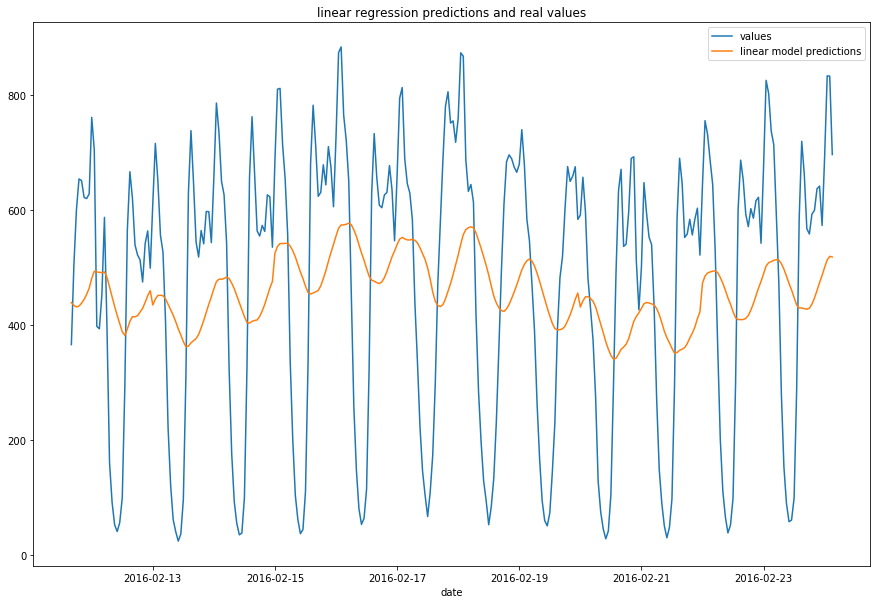

In [9]:
regressor.fit(series_4.drop(['value_mean'], axis=1).fillna(0), series_4['value_mean'])
plt.figure(figsize(15,10))
plt.plot(series_4.value_mean[1000:1300], label='values')
plt.plot(series_4.index[1000:1300], regressor.predict(series_4.drop(['value_mean'], axis=1).fillna(0))[1000:1300], 
         label='linear model predictions')
plt.xlabel('date')
plt.title('linear regression predictions and real values')
plt.legend()
plt.show()

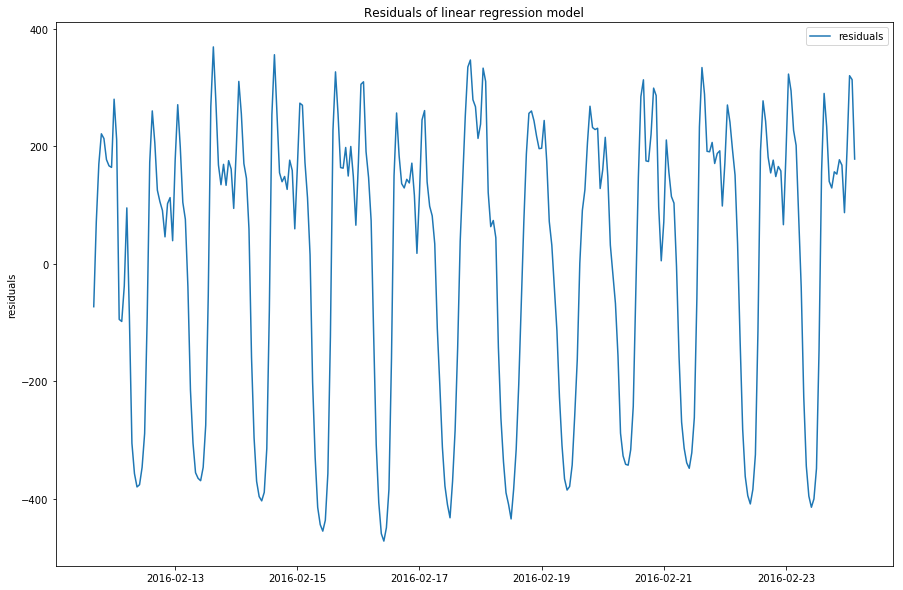

In [10]:
plt.figure(figsize(15,10))
series_4['predictions'] = regressor.predict(series_4.drop(['value_mean'], axis=1).fillna(0))
series_4['residuals'] = series_4['value_mean'] - series_4['predictions']
plt.plot(series_4.residuals[1000:1300], label='residuals')
plt.ylabel('residuals')
plt.title('Residuals of linear regression model')
plt.legend()
plt.show()

Dickey - Fuller test: p-value = 1.3823275543140122e-15


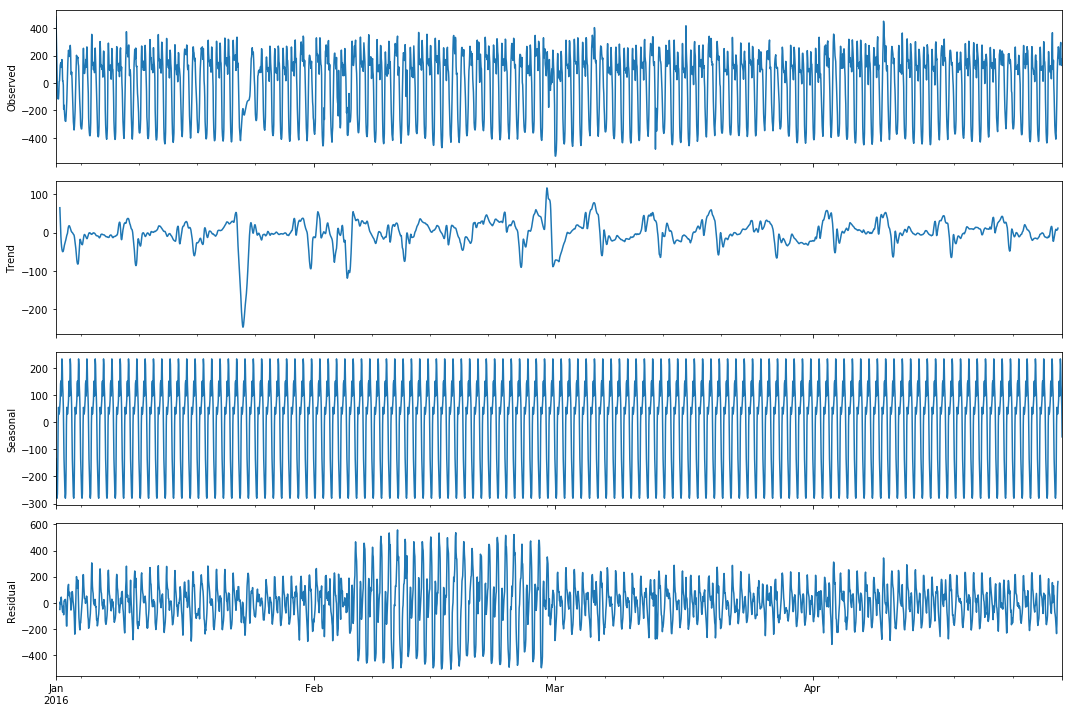

In [13]:
print("Dickey - Fuller test: p-value = {}".format(sm.tsa.stattools.adfuller(series_4.residuals)[1]))
sm.tsa.seasonal_decompose(series_4.residuals).plot()
plt.show()

In [14]:
series_4['residuals_24'] = series_4['residuals'] - series_4['residuals'].shift(24)

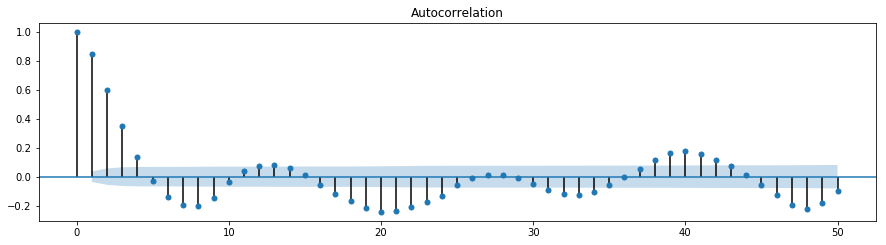

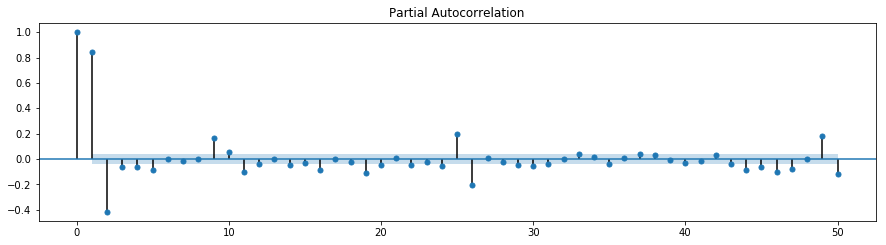

In [15]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(series_4.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(series_4.residuals_24.dropna().squeeze(), lags=50, ax=ax)
pylab.show()

q = 3; Q = 2;

p = 3; P = 2;

d = 0; D = 1

In [17]:
from itertools import product
D = 1
d = 0
ps = range(4)
qs = range(4)
Ps = range(3)
Qs = range(3)
parameters_list_4 = list(product(ps, qs, Ps, Qs))
print('amount of different models: {}'.format(len(parameters_list_4)))

amount of different models: 144


In [18]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for i, param in enumerate(parameters_list_4):
    try:
        model = sm.tsa.statespace.SARIMAX(series_4.residuals,
                                          order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_4 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print('{} out of {} '.format(i, len(parameters_list_4)))
    
warnings.filterwarnings('default')

0 out of 144 
1 out of 144 
2 out of 144 
3 out of 144 
4 out of 144 
5 out of 144 
6 out of 144 
7 out of 144 
8 out of 144 
27 out of 144 
28 out of 144 
29 out of 144 
30 out of 144 
31 out of 144 
32 out of 144 
33 out of 144 
34 out of 144 
35 out of 144 
36 out of 144 
37 out of 144 
38 out of 144 
39 out of 144 
40 out of 144 
41 out of 144 
42 out of 144 
43 out of 144 
44 out of 144 
45 out of 144 
46 out of 144 
47 out of 144 
48 out of 144 
49 out of 144 
50 out of 144 
51 out of 144 
52 out of 144 
53 out of 144 
54 out of 144 
55 out of 144 
56 out of 144 
57 out of 144 
58 out of 144 
59 out of 144 
60 out of 144 
61 out of 144 
62 out of 144 
63 out of 144 
64 out of 144 
65 out of 144 
66 out of 144 
67 out of 144 
68 out of 144 
69 out of 144 
70 out of 144 
71 out of 144 
72 out of 144 
73 out of 144 
74 out of 144 
75 out of 144 
76 out of 144 
77 out of 144 
78 out of 144 
79 out of 144 
80 out of 144 
81 out of 144 
82 out of 144 
83 out of 144 
84 out of 144 
85 o

In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters           aic
101  (3, 1, 0, 2)  31047.688645
106  (3, 1, 2, 1)  31054.670015
88   (2, 3, 2, 1)  31057.997753
115  (3, 3, 2, 1)  31058.717946
83   (2, 3, 0, 2)  31059.448938


In [21]:
best_params_dict['cluster 5'] = (3, 1, 0, 2)
series_4['model'] = best_model_4.fittedvalues
series_4['final_predict'] = series_4.model + series_4.predictions

## Best model

In [ ]:
print(best_model_4.summary())